In [1]:
# imports
import os
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# local
import acquire as a
import prepare as p


# Model Exercises for Time Series

## Exercises

Using saas.csv (https://ds.codeup.com/saas.csv) or log data from API usage


In [2]:
def get_saas():
    # name of cached csv
    filename = 'saas.csv'
    # if cached data exist
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    # wrangle from sql db if not cached
    else:
        df = pd.read_csv('https://ds.codeup.com/saas.csv')
        # cache data locally
        df.to_csv(filename, index=False)
    return df
df = get_saas()
df

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...,...
790453,2017-12-31,1029395,5790453,0.0,0.0
790454,2017-12-31,1029396,5790454,0.0,0.0
790455,2017-12-31,1029397,5790455,3.0,15.0
790456,2017-12-31,1029398,5790456,0.0,0.0


In [3]:
df.columns = df.columns.str.lower()

In [4]:
df.month_invoiced = pd.to_datetime(df.month_invoiced)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   month_invoiced     790458 non-null  datetime64[ns]
 1   customer_id        790458 non-null  int64         
 2   invoice_id         790458 non-null  int64         
 3   subscription_type  790458 non-null  float64       
 4   amount             790458 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 30.2 MB


In [5]:
df = df.set_index('month_invoiced').sort_index()
df

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...
2017-12-31,1029395,5790453,0.0,0.0
2017-12-31,1029396,5790454,0.0,0.0
2017-12-31,1029397,5790455,3.0,15.0


### 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.


In [6]:
df_m = df.drop(columns=['customer_id','invoice_id','subscription_type']).resample('M').sum()
df_m

,amount
month_invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0
2014-06-30,41255.0
2014-07-31,42170.0
2014-08-31,43210.0
2014-09-30,44075.0


In [10]:
train_val = pd.DataFrame()
for train_val_index, test_index in TimeSeriesSplit(6).split(df_m):
    train_val,test=df_m.iloc[train_val_index],df_m.iloc[test_index]
train_val = train_val.reset_index()
train_val.describe(include='all')


,month_invoiced,amount
count,42,42.000000
mean,2015-10-15 12:34:17.142857216,48700.238095
min,2014-01-31 00:00:00,35850.000000
25%,2014-12-07 18:00:00,45711.250000
50%,2015-10-15 12:00:00,51122.500000
75%,2016-08-23 06:00:00,52878.750000
max,2017-06-30 00:00:00,53480.000000
std,NaN,5185.993796


In [12]:
train = pd.DataFrame()
for train_index, val_index in TimeSeriesSplit(5).split(train_val):
    train,val=train_val.iloc[train_index],train_val.iloc[val_index]
train.reset_index().describe()


,index,month_invoiced,amount
count,35.000000,35,35.000000
mean,17.000000,2015-06-30 23:18:51.428571392,47762.285714
min,0.000000,2014-01-31 00:00:00,35850.000000
25%,8.500000,2014-10-15 12:00:00,44477.500000
50%,17.000000,2015-06-30 00:00:00,49485.000000
75%,25.500000,2016-03-15 12:00:00,51977.500000
max,34.000000,2016-11-30 00:00:00,53375.000000
std,10.246951,NaN,5195.890534


### 2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:


In [17]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    return round(
        mean_squared_error(
            val[target_var], yhat_df[target_var], squared=False
        ),
        0,
    )
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als label the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(val[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var], label='Pred', linewidth=1)
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, f'-- rmse: {round(rmse,2)}')
    plt.show()
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    return pd.concat([eval_df, pd.DataFrame(d)])

#### - Last Observed Value


In [18]:
train['amount'][-1:][0]

53375.0

In [19]:
last_amount = train['amount'][-1:][0]
yhat_df = pd.DataFrame(
    {
        'amount':[last_amount]
    },
    index=val.index
)
yhat_df.head()

,amount
35,53375.0
36,53375.0
37,53375.0
38,53375.0
39,53375.0


In [26]:
train = train.reset_index()


In [27]:
eval_df

,model_type,target_var,rmse


#### - Simple Average


In [ ]:
avg_amount = round(train.amount.mean(),2)
yhat_df = pd.DataFrame(
    {
        'amount':[avg_amount]
    },
    index=val.index
)
yhat_df.head()

,amount
month_invoiced,
2016-12-31,47762.29
2017-01-31,47762.29
2017-02-28,47762.29
2017-03-31,47762.29
2017-04-30,47762.29


amount -- rmse: 5628.0


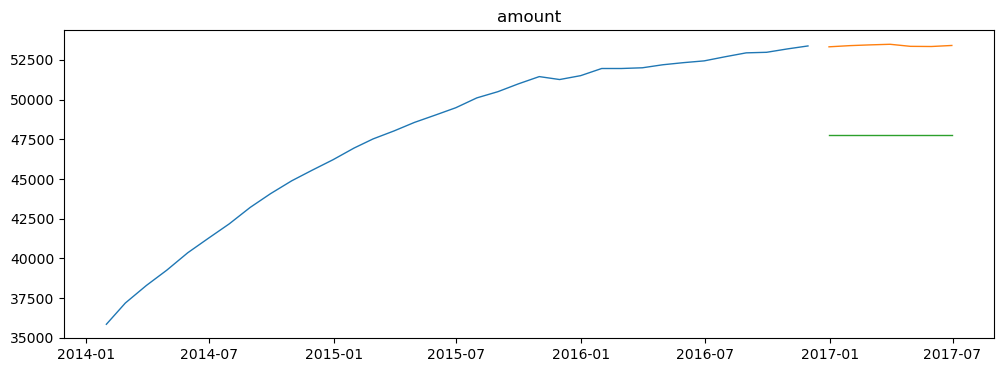

In [ ]:
plot_and_eval('amount')

In [ ]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_obs_val,amount,55.0
0,simple_average,amount,5628.0


#### - Moving Average


In [ ]:
period = 3
rolling_amount = round(train.amount.rolling(period).mean()[-1],2)
yhat_df = pd.DataFrame({'amount':rolling_amount},index=val.index)
yhat_df.head()

,amount
month_invoiced,
2016-12-31,53180.0
2017-01-31,53180.0
2017-02-28,53180.0
2017-03-31,53180.0
2017-04-30,53180.0


amount -- rmse: 217.0


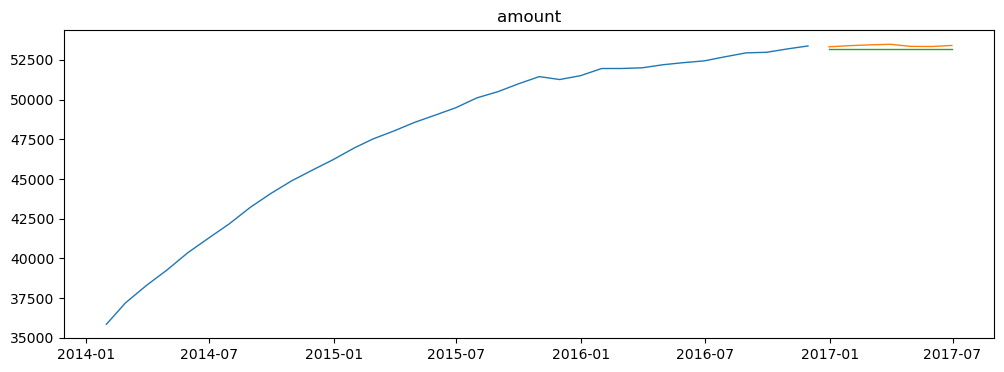

In [ ]:
plot_and_eval('amount')

In [ ]:
eval_df = append_eval_df(model_type='3m_roll_avg',target_var='amount')
eval_df

,model_type,target_var,rmse
0,last_obs_val,amount,55.0
0,simple_average,amount,5628.0
0,3m_roll_avg,amount,217.0


In [ ]:
periods = [1,2,3,4,5,6]
for p in periods:
    rolling_amount = round(train.amount.rolling(p).mean()[-1],2)
    yhat_df = pd.DataFrame({
        'amount':[rolling_amount]
    },index=val.index)
    model_type = f'{p}m_roll_avg'
    eval_df = append_eval_df(model_type=model_type,target_var='amount')

In [ ]:
eval_df

,model_type,target_var,rmse
0,last_obs_val,amount,55.0
0,simple_average,amount,5628.0
0,3m_roll_avg,amount,217.0
0,1m_roll_avg,amount,55.0
0,2m_roll_avg,amount,120.0
0,3m_roll_avg,amount,217.0
0,4m_roll_avg,amount,275.0
0,5m_roll_avg,amount,359.0
0,6m_roll_avg,amount,458.0


#### - Holt's Linear Trend


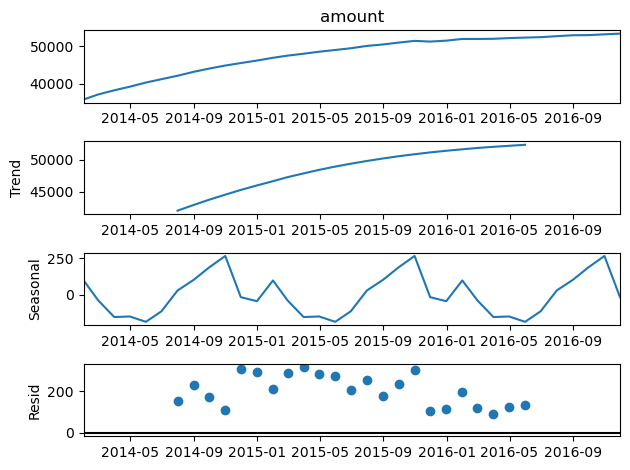

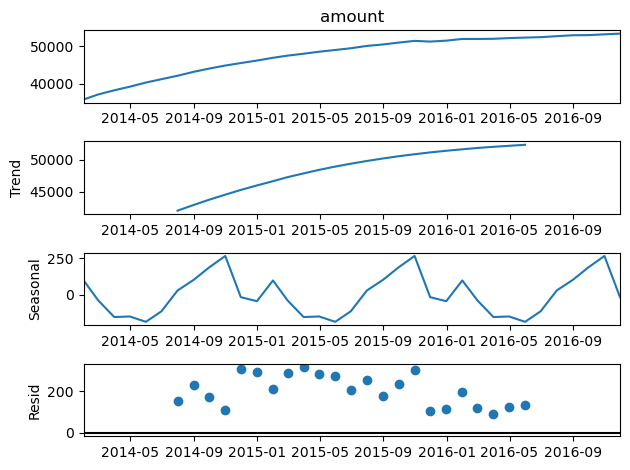

In [ ]:
sm.tsa.seasonal_decompose(train['amount']).plot()

In [ ]:
model = Holt(train['amount'],damped_trend=True).fit()
yhat_val = model.predict(start=val.index[0],end=val.index[-1])
yhat_df['amount'] = round(yhat_val,2)

In [ ]:
yhat_df.head()

,amount
month_invoiced,
2016-12-31,53511.49
2017-01-31,53647.30
2017-02-28,53770.68
2017-03-31,53882.77
2017-04-30,53984.59


amount -- rmse: 520.0


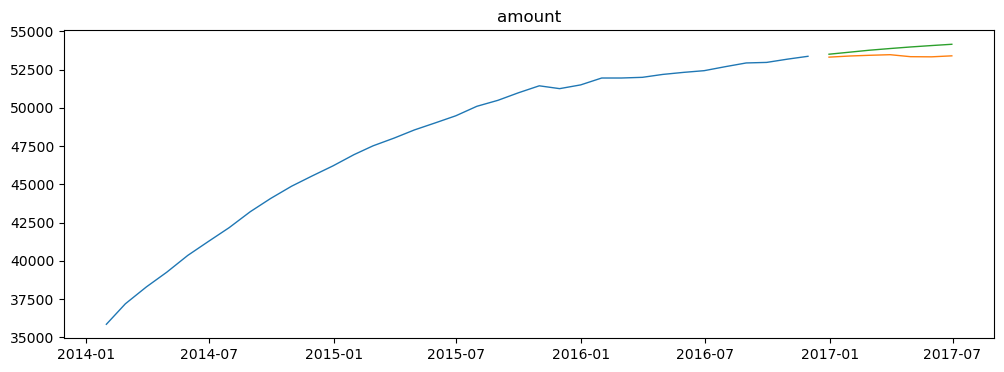

In [ ]:
plot_and_eval('amount')

In [ ]:
eval_df = append_eval_df(model_type='holt_lin',target_var='amount')

#### - Holt's Seasonal Trend


In [ ]:
combos = list(itertools.product(['add','mul'],[True,False]))
combos

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [ ]:
hsts = {'amount': {}}
for i,combo in enumerate(combos):
    es = ExponentialSmoothing(train['amount'],
                            seasonal_periods=12,
                            trend='add',
                            seasonal=combo[0],
                            damped_trend=combo[1])
    hsts['amount'][f'hst_fit_{i}'] = es.fit()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
hsts.keys()

dict_keys(['amount'])

In [ ]:
hsts['amount']

{'hst_fit_0': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x157c7dcd0>,
 'hst_fit_1': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x173b78fa0>,
 'hst_fit_2': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x173b78a90>,
 'hst_fit_3': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x173b8c8e0>}

In [ ]:
best = ''
for model in hsts['amount']:
    score = (hsts['amount'][model].sse/len(train))**.5
    curr_model = {model: score}
    if best == '':
        best = curr_model
    elif list(best.values())[0] > list(curr_model.values())[0]:
        best = curr_model

In [ ]:
best

{'hst_fit_1': 992.9775284647836}

In [ ]:
train.shape, val.shape, test.shape

((35, 1), (7, 1), (6, 1))

In [ ]:
val.head(1)

,amount
month_invoiced,
2016-12-31,53320.0


In [ ]:
hsts['amount']['hst_fit_1'].forecast(val.shape[0]+1)

2016-12-31    53508.443274
2017-01-31    52336.407838
2017-02-28    53699.626391
2017-03-31    53775.291129
2017-04-30    53809.192180
2017-05-31    53949.216383
2017-06-30    53968.874161
2017-07-31    54223.686102
Freq: M, dtype: float64

In [ ]:
yhat_df = pd.DataFrame({'amount':hsts['amount']['hst_fit_1'].forecast(val.shape[0] + 1)},index=val.index)
yhat_df

,amount
month_invoiced,
2016-12-31,53508.443274
2017-01-31,52336.407838
2017-02-28,53699.626391
2017-03-31,53775.291129
2017-04-30,53809.192180
2017-05-31,53949.216383
2017-06-30,53968.874161


amount -- rmse: 562.0


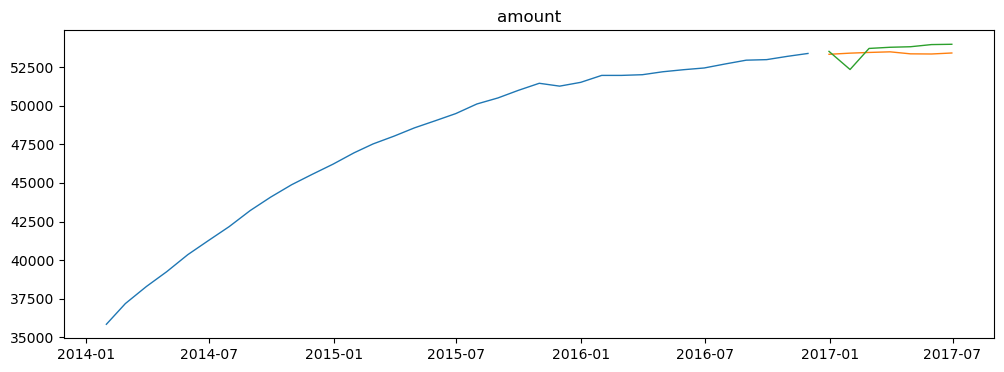

In [ ]:
plot_and_eval('amount')

In [ ]:
eval_df = append_eval_df(model_type='holt_seas',target_var='amount')
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_obs_val,amount,55.0
0,1m_roll_avg,amount,55.0
0,2m_roll_avg,amount,120.0
0,3m_roll_avg,amount,217.0
0,3m_roll_avg,amount,217.0
0,4m_roll_avg,amount,275.0
0,5m_roll_avg,amount,359.0
0,6m_roll_avg,amount,458.0
0,holt_lin,amount,520.0
0,holt_seas,amount,562.0


#### - Based on previous year/month/etc., this is up to you.

In [ ]:
train = df_m.loc[:'2015']
val = df_m.loc['2016']
test = df_m.loc['2017']

In [ ]:
yhat_df = train.loc['2015'] + train.diff(12).mean()
yhat_df.index = val.index
yhat_df

,amount
month_invoiced,
2016-01-31,55033.75
2016-02-29,55608.75
2016-03-31,56113.75
2016-04-30,56648.75
2016-05-31,57113.75
2016-06-30,57573.75
2016-07-31,58193.75
2016-08-31,58583.75
2016-09-30,59073.75


amount -- rmse: 5192.0


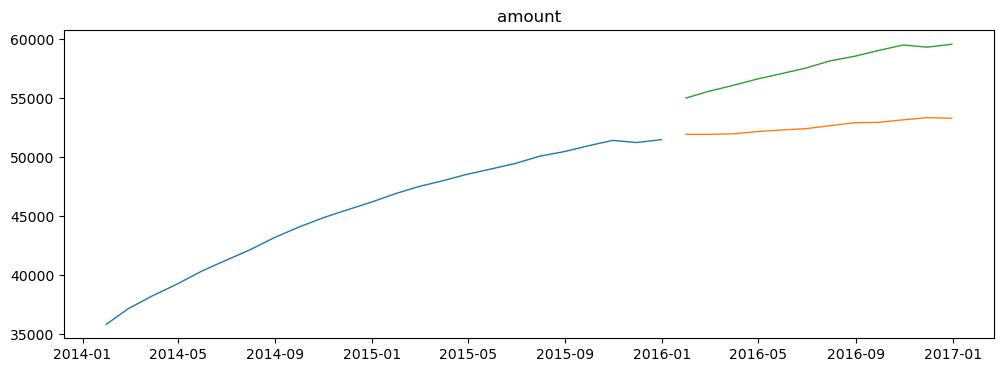

In [ ]:
plot_and_eval('amount')
eval_df = append_eval_df(model_type='prev_yr',target_var='amount')

In [ ]:
eval_df.sort_values('rmse')

,model_type,target_var,rmse
0,last_obs_val,amount,55.0
0,1m_roll_avg,amount,55.0
0,2m_roll_avg,amount,120.0
0,3m_roll_avg,amount,217.0
0,3m_roll_avg,amount,217.0
0,4m_roll_avg,amount,275.0
0,5m_roll_avg,amount,359.0
0,6m_roll_avg,amount,458.0
0,holt_lin,amount,520.0
0,holt_seas,amount,562.0


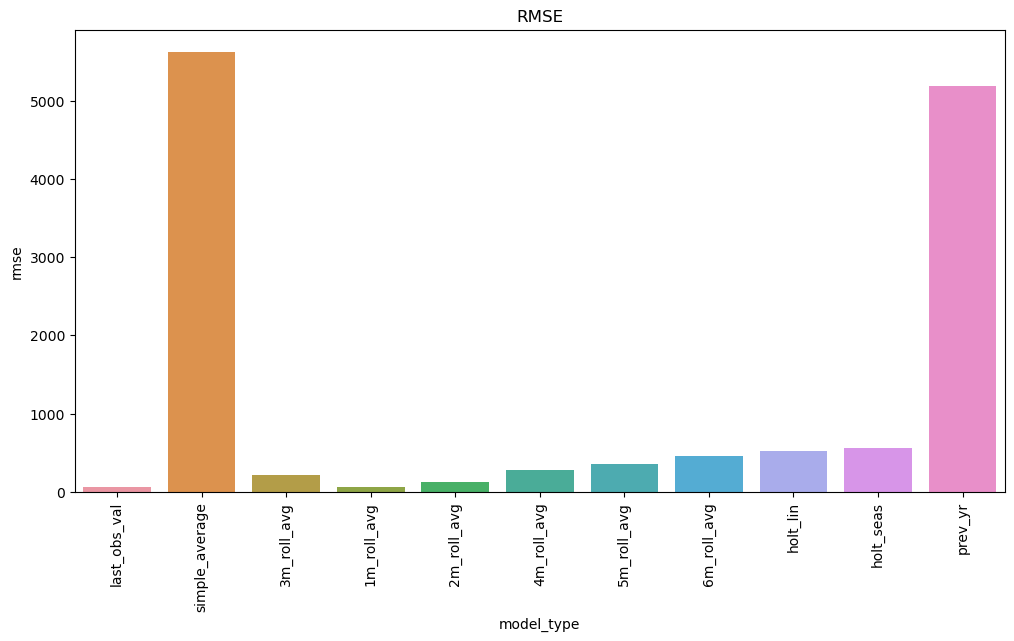

In [ ]:
x=eval_df['model_type']
y=eval_df['rmse']
plt.figure(figsize=(12,6))
sns.barplot(x=x,y=y)
plt.title('RMSE')
plt.xticks(rotation=90)
plt.show()

In [ ]:
for train_val_index, test_index in TimeSeriesSplit(6).split(df_m):
    train_val,test=df_m.iloc[train_val_index],df_m.iloc[test_index]
for train_index, val_index in TimeSeriesSplit(5).split(train_val):
    train,val=train_val.iloc[train_index],train_val.iloc[val_index]
train.shape, val.shape, test.shape

((35, 1), (7, 1), (6, 1))

In [ ]:
test

,amount
month_invoiced,
2017-07-31,53680.0
2017-08-31,53820.0
2017-09-30,53925.0
2017-10-31,53850.0
2017-11-30,53860.0
2017-12-31,53805.0


In [ ]:
last_amount = train['amount'][-1:][0]
yhat_df = pd.DataFrame({'amount': last_amount},index=test.index)
yhat_df

,amount
month_invoiced,
2017-07-31,53375.0
2017-08-31,53375.0
2017-09-30,53375.0
2017-10-31,53375.0
2017-11-30,53375.0
2017-12-31,53375.0


In [ ]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(val[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-sales total:  454.4777222262935


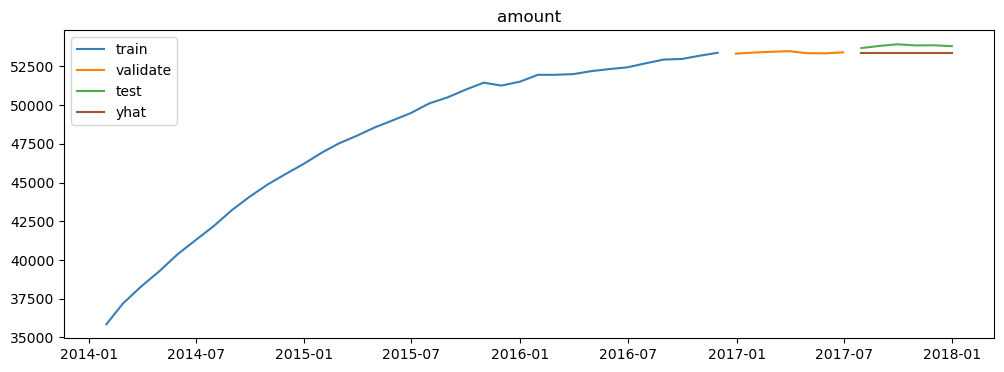

In [ ]:
rmse_sales_total = (mean_squared_error(test['amount'],yhat_df['amount']))**.5
print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-sales total: ', rmse_sales_total)
final_plot('amount')